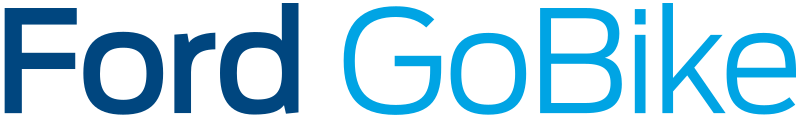

In [1]:
from IPython.display import Image, display
display(Image('https://upload.wikimedia.org/wikipedia/commons/thumb/7/78/Ford_GoBike_logo.svg/800px-Ford_GoBike_logo.svg.png'))

# Ford GoBike System Data Flights Analysis
## by *Furawa*

## Dataset Overview

The Ford GoBike System Data Flights includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area.  We will use the data of the year 2018, which is about 1863721 rides all over the year in different locations. The rides are made by different gender, people of all age, subcribers and customers. 


## Investigation Overview  
In this investigation the main focus is to know When and where most of the trips are taken in terms of time of a day, day of the week, or month of the year. We also want to know if this depend on if is a subscriber or a customer a Male or a Female a young or an old person.

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt  
import requests
import os
import zipfile
import re
import datetime

%matplotlib inline

In [3]:
# Load the wrangled data from the Exploration part
baywheels_data = pd.read_csv('baywheels_data.csv')

In [4]:
print(baywheels_data.shape)  
print(baywheels_data.dtypes)
baywheels_data.head()

(1863721, 17)
duration_sec                 int64
start_time                  object
end_time                    object
start_station_id             int64
start_station_name          object
start_station_latitude     float64
start_station_longitude    float64
end_station_id               int64
end_station_name            object
end_station_latitude       float64
end_station_longitude      float64
bike_id                      int64
user_type                   object
member_birth_year          float64
member_gender               object
bike_share_for_all_trip     object
duration_groups             object
dtype: object


,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration_groups
0,71766,2018-03-31 16:58:33.149,2018-04-01 12:54:39.263,4,Cyril Magnin St at Ellis St,37.785881,-122.408915,6,The Embarcadero at Sansome St,37.804770,-122.403234,341,Customer,1964.0,Female,No,12h++
1,62569,2018-03-31 19:03:35.916,2018-04-01 12:26:25.035,78,Folsom St at 9th St,37.773717,-122.411647,47,4th St at Harrison St,37.780955,-122.399749,536,Subscriber,1984.0,Male,No,12h++
2,56221,2018-03-31 20:13:13.564,2018-04-01 11:50:14.840,258,University Ave at Oxford St,37.872355,-122.266447,239,Bancroft Way at Telegraph Ave,37.868813,-122.258764,3245,Customer,1983.0,Male,No,12h++
3,85844,2018-03-31 11:28:07.658,2018-04-01 11:18:52.613,186,Lakeside Dr at 14th St,37.801319,-122.262642,340,Harmon St at Adeline St,37.849735,-122.270582,3722,Customer,NaN,Other,No,12h++
4,1566,2018-03-31 23:37:56.640,2018-04-01 00:04:02.893,193,Grand Ave at Santa Clara Ave,37.812744,-122.247215,196,Grand Ave at Perkins St,37.808894,-122.256460,2355,Subscriber,1979.0,Male,No,15-30mn


All the files are in one unique dataframe `baywheels_data`, but there are many issues to fix before using the 
dataframe. Many columns does not have the correct data type(start_time, end_time, start_station_id,end_station_id,
user_type,member_birth_year,member_gender).

In [5]:
# Change the data type of start_time and end_time from object to date_time
baywheels_data.start_time = pd.to_datetime(baywheels_data.start_time, format = '%Y-%m-%d %H:%M:%S.%f')
baywheels_data.end_time = pd.to_datetime(baywheels_data.end_time, format = '%Y-%m-%d %H:%M:%S.%f')

In [6]:
# Assert that the changes are correct, no output means it is correct
assert baywheels_data.start_time.dtypes == '<datetime64[ns]'
assert baywheels_data.end_time.dtypes == '<datetime64[ns]'

In [7]:
# member_birth_year from float to int, we use Int64 instead of int64 to make it work
baywheels_data.member_birth_year = baywheels_data.member_birth_year.astype('Int64')           

In [8]:
# Check if the data type is correct, no output means it is correct 
assert baywheels_data.member_birth_year.dtypes == 'Int64'

In [9]:
# Change the data type of member_gender from string to category
baywheels_data.member_gender = baywheels_data.member_gender.fillna('Other') # Change the NaNs values to other
baywheels_data.member_gender = baywheels_data.member_gender.astype('category')

In [10]:
# Check if the data type is correct, no output means it is correct
assert baywheels_data.member_gender.dtypes == 'category'

In [11]:
# Change the user type from string to category  
baywheels_data.user_type = baywheels_data.user_type.astype('category')

In [12]:
# Check the changes, no output means it is correct
assert baywheels_data.user_type.dtypes == 'category'

In [13]:
baywheels_data.start_station_id = baywheels_data.start_station_id.fillna(0) # Replace the NaNs values with 0 
baywheels_data.end_station_id = baywheels_data.end_station_id.fillna(0)     # Replace the NaNs values with 0 
# Change data type of start_station_id and end_station_id from float to int
baywheels_data.start_station_id = baywheels_data.start_station_id.astype(int)
baywheels_data.end_station_id = baywheels_data.end_station_id.astype(int)

In [14]:
# Check the changes, no output means it is ok
assert baywheels_data.start_station_id.dtypes == 'int64'
assert baywheels_data.end_station_id.dtypes == 'int64'

In [15]:
# Some descriptives statistics for numeric variables
baywheels_data.describe()

,duration_sec,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bike_id,member_birth_year
count,1.863721e+06,1.863721e+06,1.863721e+06,1.863721e+06,1.863721e+06,1.863721e+06,1.863721e+06,1.863721e+06,1.751843e+06
mean,8.573026e+02,1.189186e+02,3.776678e+01,-1.223492e+02,1.174266e+02,3.776690e+01,-1.223487e+02,2.296851e+03,1.983141e+03
std,2.370379e+03,1.005281e+02,1.057689e-01,1.654634e-01,1.005593e+02,1.056483e-01,1.650597e-01,1.287733e+03,1.023871e+01
min,6.100000e+01,0.000000e+00,3.726331e+01,-1.224737e+02,0.000000e+00,3.726331e+01,-1.224737e+02,1.100000e+01,1.920000e+03
25%,3.500000e+02,3.000000e+01,3.777106e+01,-1.224114e+02,3.000000e+01,3.777106e+01,-1.224094e+02,1.225000e+03,1.978000e+03
50%,5.560000e+02,8.800000e+01,3.778107e+01,-1.223974e+02,8.700000e+01,3.778127e+01,-1.223971e+02,2.338000e+03,1.985000e+03
75%,8.720000e+02,1.830000e+02,3.779625e+01,-1.222865e+02,1.830000e+02,3.779728e+01,-1.222894e+02,3.333000e+03,1.991000e+03
max,8.636600e+04,3.810000e+02,4.551000e+01,-7.357000e+01,3.810000e+02,4.551000e+01,-7.357000e+01,6.234000e+03,2.000000e+03


**Structure of the Dataset**  
There are 1863721 rows and 16 variables in the dataset(duration_sec, start_time, end_time, start_station_id, start_station_name, start_station_latitude, start_station_longitude, end_station_id, end_station_name, end_station_latitude, end_station_longitude, bike_id, user_type, member_birth_year, member_gender, bike_share_for_all_trip), 9 of these are numerical variables.

**Main features of interest in the dataset**  
We are more interested in figuring out what factors or features affect the place a trip is taken and the duration of the trips.

**Features That will help support our investigation into our features of interest**  
Probably during the summer and holidays there will be more trip and for more time so the variables start_time and
end_time will probably have the major effect on the duration, we can also expect that subscriber takes more trips
than customers, we can expect that young people have many trips than old people.


## Univariate Exploration

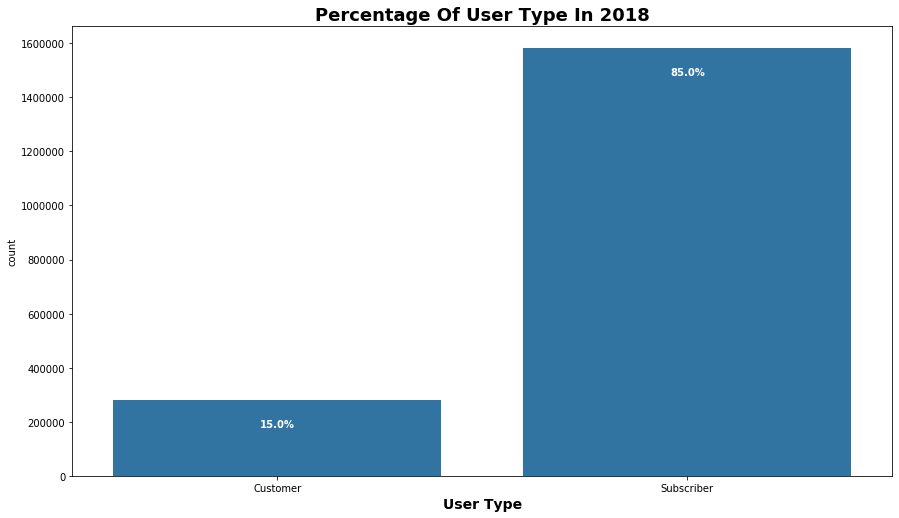

In [16]:
# Create the plot of the user type
plt.figure(figsize=[14.70, 8.27])
base_color = sb.color_palette()[0]
sb.countplot(data = baywheels_data, x = 'user_type', color = base_color)
plt.xlabel('User Type'.title(), fontsize = 14, weight = 'bold')
plt.title('Percentage of User Type in 2018'.title(), fontsize = 18, weight = 'bold');

# add annotations 
n_points = baywheels_data.shape[0]
cat_counts = baywheels_data.user_type.value_counts()
locs, labels = plt.xticks()

# loop through each pair of location and label
for loc, label in zip(locs, labels):
    count = cat_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/n_points)
    plt.text(loc, count-100000, pct_string, ha = 'center', color = 'w', weight = 'bold')

During the year 2018 out of **1,863,721** trips, **85%**(1,584,162) of the trips are made by Subscribers users and only **15%**(279558) are made by Customers.

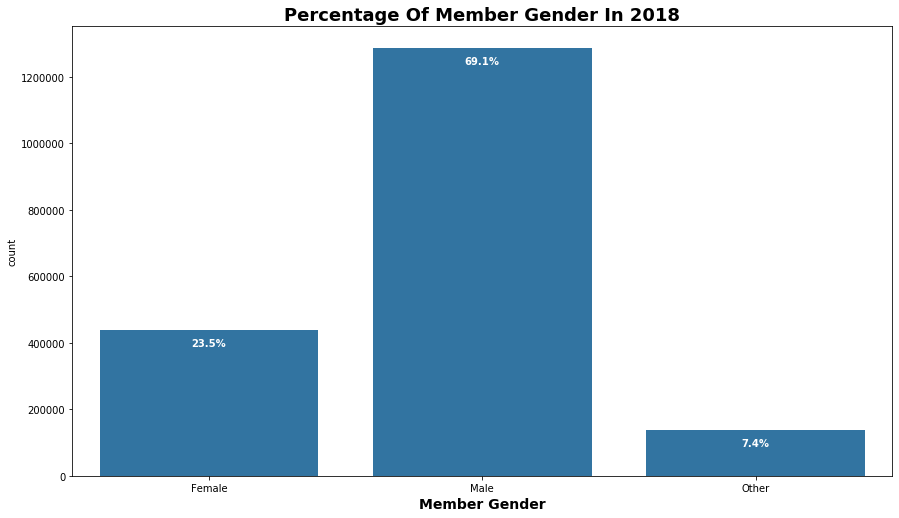

In [17]:
# Plot Member gender
plt.figure(figsize=[14.70, 8.27])
sb.countplot(data = baywheels_data, x = 'member_gender', color = base_color)
plt.xlabel('Member Gender'.title(), fontsize = 14, weight = 'bold')
plt.title('Percentage of Member Gender in 2018'.title(), fontsize = 18, weight = 'bold' )
# add annotations 
gender_points = baywheels_data.shape[0]
gender_counts = baywheels_data.member_gender.value_counts()
gender_locs, gender_labels = plt.xticks()

# loop through each pair of location and label
for loc, label in zip(gender_locs, gender_labels):
    count = gender_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/gender_points)
    plt.text(loc, count-48000, pct_string, ha = 'center', color = 'w', weight = 'bold')

**69.1%** of the trips are made by Men and just around **23.5%** are made by Women. There are *7.4%* which is made by gender of Other type, in this group there are also wrong values or bad entries.

## Bike Share for All Option

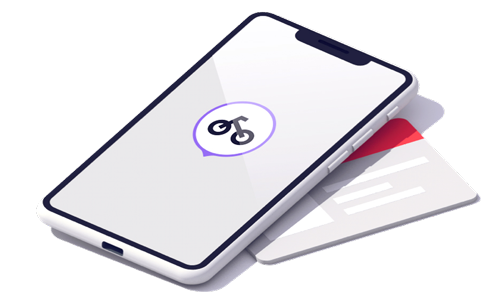

In [18]:
display(Image('https://images.ctfassets.net/q8mvene1wzq4/6sb2hCQ6luI0DuA76rO14w/d56a4844d2dc805f401bf76d1b8e1e9c/bikes-getting-approved.png'))

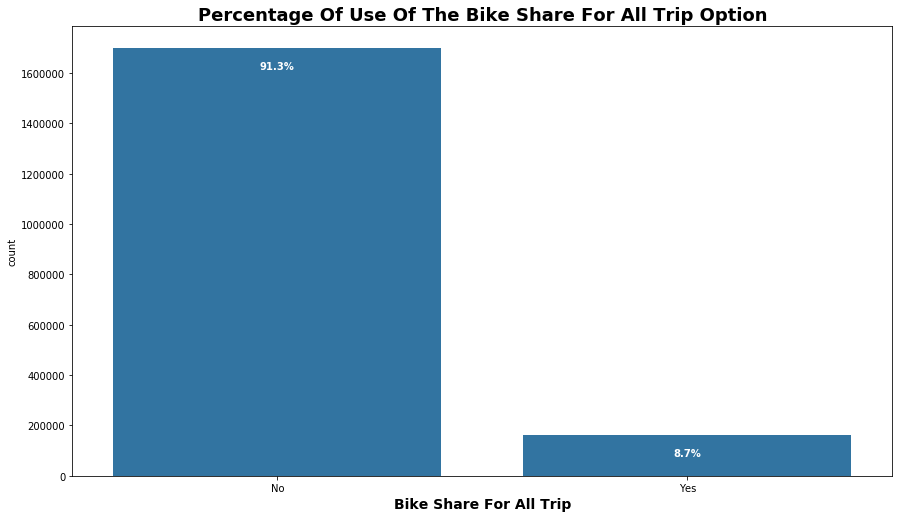

In [19]:
plt.figure(figsize=[14.70, 8.27])
sb.countplot(data = baywheels_data, x = 'bike_share_for_all_trip', color = base_color)
plt.xlabel('Bike Share For All Trip'.title(), fontsize = 14, weight = 'bold')
plt.title('Percentage of Use of the Bike Share For All Trip Option'.title(), size = 18, weight = 'bold')

option_points = baywheels_data.shape[0]
option_counts = baywheels_data.bike_share_for_all_trip.value_counts()
option_locs, gender_labels = plt.xticks()

# loop through each pair of location and label
for loc, label in zip(option_locs, gender_labels):
    count = option_counts[label.get_text()]
    pct_string = '{:0.1f}%'.format(100*count/option_points)
    plt.text(loc, count-85000, pct_string, ha = 'center', color = 'w', weight = 'bold');

Bay Wheels offers all residents of the Bay Area an affordable ,accessible and fun new transportation option, 
"*The Bike Share for All*", however this option seems to not attract many people, in fact just **8.7%** of all trips during the year 2018 are made using the option.

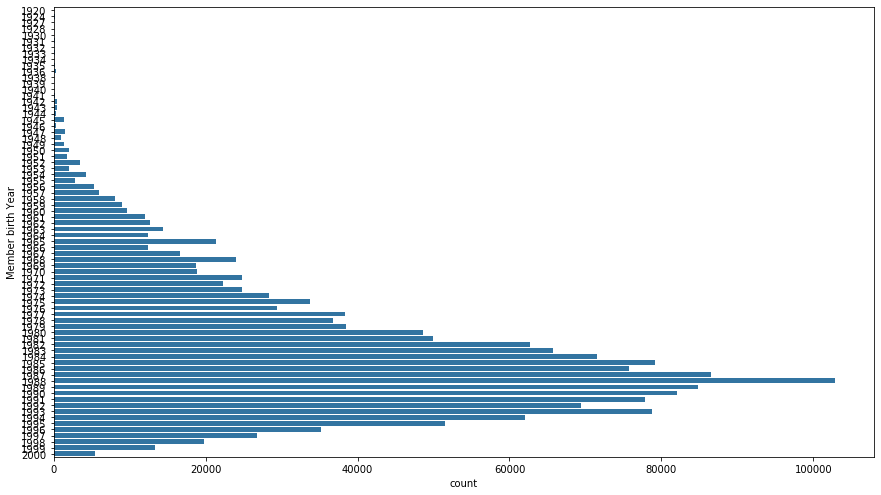

In [20]:
# Plot of the member_birth_year 
plt.figure(figsize=[14.70, 8.27])
sb.countplot(data = baywheels_data, y = 'member_birth_year', color = base_color)
plt.ylabel('Member birth Year');

Looking at this plot we figure out that there are many outliers. Let us go deep.

In [21]:
# Check all the member birth year higher than 100 years 
wrong_birth_values = baywheels_data[baywheels_data.member_birth_year < 1918].member_birth_year
wrong_birth_values.value_counts().index

Index([], dtype='object')

All those values are probably errors, the oldest people in the world are around 116 years old and most of them live in Japan, in the other hand [the oldest](https://www.oldest.org/people/living-people-usa/) people in the USA are around 112 years old and are not in a state of driving a bicycle. We will consider in this analysis that all the people with more than 100 years old are wrong values probably due to data entry and turn all these values to NaNs.

In [22]:
# Turn all the member_birth_year wrong values to NaNs
for val in wrong_birth_values.value_counts().index:
    baywheels_data.member_birth_year[baywheels_data.member_birth_year == val] = np.nan

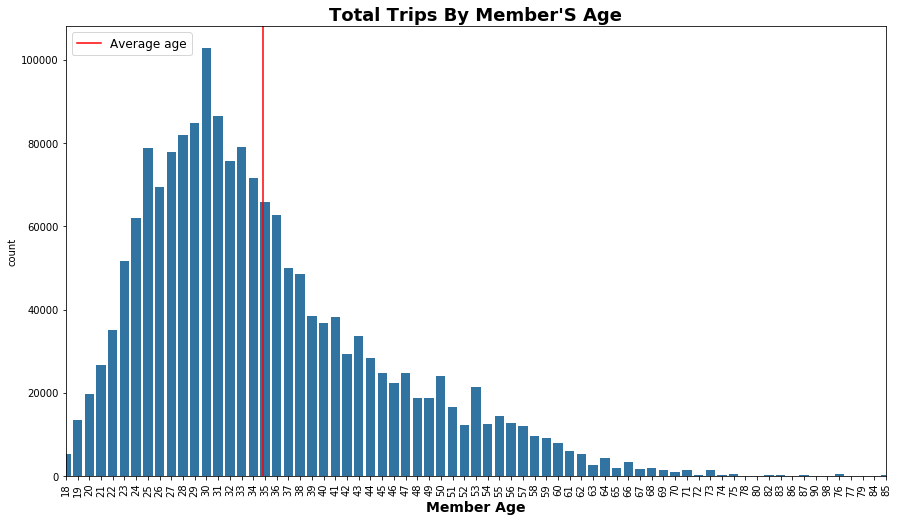

In [23]:
# Use age instead of year 
baywheels_data['member_age'] = pd.DatetimeIndex(baywheels_data.start_time).year.max() - baywheels_data.member_birth_year 
# Change the size of the plot
plt.figure(figsize=[14.70, 8.27])
# Plot the count of each member birth year
sb.countplot(data = baywheels_data, x = 'member_age', color = base_color)
# label the y axis
plt.xlabel('Member Age'.title(), fontsize = 14, weight = 'bold')
plt.xlim([0,70])
plt.xticks(rotation = 90)
plt.title("Total trips by Member's Age".title(), fontsize = 18, weight = 'bold')
plt.axvline(x = baywheels_data.member_age.mean() - 18, c = 'r', label = 'Average age'); # -18 because we start at 18 on the axis
plt.legend(loc = 'upper left', fontsize = 12);

There are users with more than 100 years old, we did not take them in consideration because there are probably bad entries, we just considered the users with less than 85 years old in this plot, and as we can see there are very few of them. On the other hand the rides are made by young people and we have the peak at 30 years old. We have an average years old of 35, and the youngest riders have 18 years old.

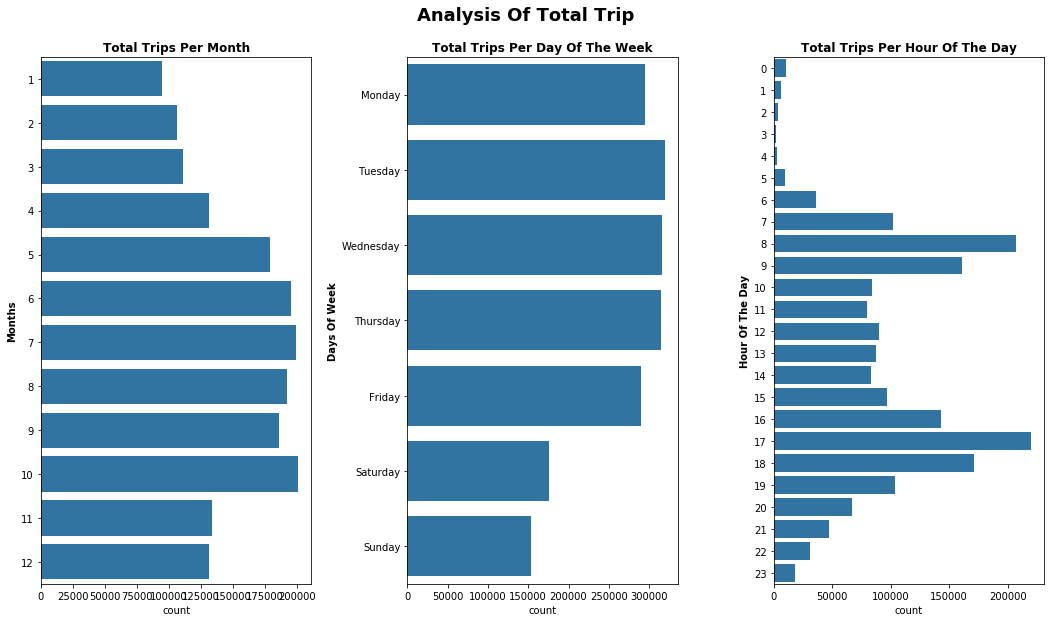

In [24]:
# Change the size of the plots
plt.figure(figsize=[14.70, 8.27])

plt.suptitle('Analysis of Total Trip'.title(), fontsize = 18, weight = 'bold', y = 1.04)
# Add the Month plot on row 1 col 1
plt.subplot(1,3,1)

months = pd.DatetimeIndex(baywheels_data.start_time).month
sb.countplot(y = months, color = base_color)
plt.ylabel('Months'.title(), fontsize = 10, weight = 'bold')
plt.title('Total Trips per Month'.title(), fontsize = 12, weight = 'bold')
# Add the Days plot on row 1 col 2
plt.subplot(1,3,2)

week_name = pd.DatetimeIndex(baywheels_data.start_time).weekday_name
# Order the day of the week so that it will be in that order on the plot
order_day = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sb.countplot(y = week_name, color = base_color, order = order_day)
plt.ylabel('Days of Week'.title(), fontsize = 10, weight = 'bold')
plt.title('Total Trips per Day of the week'.title(), fontsize = 12, weight = 'bold')
# Add the Hour plot on row 1 col 3
plt.subplot(1,3,3)
hours = pd.DatetimeIndex(baywheels_data.start_time).hour
sb.countplot(y = hours, color = base_color)
plt.ylabel('Hour of the Day'.title(), fontsize = 10, weight = 'bold')
plt.title('Total Trips per Hour of the Day'.title(), fontsize = 12, weight = 'bold')
plt.tight_layout();

From May(5) to October(10) we have the higher values, with the highest at October, which means that
they are the period of the year 2018 with more trips. These values are a little bit expected, in fact we have the highest values during the Summer and Autumn and the lowest during the Winter and Spring. 
In the other hands during the weekdays we have the highest values and the lowest during the weekends.  
There are more trips between 8am and 9am, and between 5pm and 6pm, which is also expected as these time of the day represents the start and the end of the work day.
This let us think that the bikes are more used when the weather is beautiful and during the working days, bikes are probably more used to go and return from work.

Let us go deep with some descriptive statistic in the duration_sec column.

In [25]:
print('Duration max :', baywheels_data.duration_sec.max())      # Print the duration max over the year
print('Duration min :', baywheels_data.duration_sec.min())      # Print the duration min over the year
print('Average duration:', baywheels_data.duration_sec.mean())  # Print the average duration over the year

Duration max : 86366
Duration min : 61
Average duration: 857.3025710393348


The average duration over the year of a single trip is about **857s** which means around **14min**, the minimum duration is about 1min, and the max duration is about **24h** for one single trip.

In [26]:
baywheels_data[baywheels_data.duration_sec == baywheels_data.duration_sec.max()]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration_groups,member_age
1514324,86366,2018-02-03 17:32:04.042,2018-02-04 17:31:30.788,197,El Embarcadero at Grand Ave,37.808848,-122.24968,197,El Embarcadero at Grand Ave,37.808848,-122.24968,1486,Customer,NaN,Other,No,12h++,NaN


Unexpectedly we have the longest trip(24h) at February by a Customer. 

In [27]:
min_df = baywheels_data[baywheels_data.duration_sec == baywheels_data.duration_sec.min()]
min_df

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,duration_groups,member_age
13644,61,2018-03-28 19:11:30.722,2018-03-28 19:12:31.898,6,The Embarcadero at Sansome St,37.804770,-122.403234,6,The Embarcadero at Sansome St,37.804770,-122.403234,3690,Subscriber,1952,Male,No,0-15mn,66
49055,61,2018-03-19 17:49:55.948,2018-03-19 17:50:57.564,162,Franklin St at 9th St,37.800516,-122.272080,162,Franklin St at 9th St,37.800516,-122.272080,3094,Subscriber,1985,Male,Yes,0-15mn,33
49143,61,2018-03-19 17:42:56.834,2018-03-19 17:43:58.801,162,Franklin St at 9th St,37.800516,-122.272080,162,Franklin St at 9th St,37.800516,-122.272080,3094,Subscriber,1985,Male,Yes,0-15mn,33
49156,61,2018-03-19 17:41:40.062,2018-03-19 17:42:41.637,162,Franklin St at 9th St,37.800516,-122.272080,162,Franklin St at 9th St,37.800516,-122.272080,3094,Subscriber,1985,Male,Yes,0-15mn,33
49183,61,2018-03-19 17:38:55.690,2018-03-19 17:39:57.490,162,Franklin St at 9th St,37.800516,-122.272080,162,Franklin St at 9th St,37.800516,-122.272080,3094,Subscriber,1985,Male,Yes,0-15mn,33
49204,61,2018-03-19 17:37:38.232,2018-03-19 17:38:39.390,162,Franklin St at 9th St,37.800516,-122.272080,162,Franklin St at 9th St,37.800516,-122.272080,3094,Subscriber,1985,Male,Yes,0-15mn,33
76044,61,2018-03-11 14:13:35.274,2018-03-11 14:14:37.174,28,The Embarcadero at Bryant St,37.787168,-122.388098,28,The Embarcadero at Bryant St,37.787168,-122.388098,3043,Customer,1989,Male,No,0-15mn,29
97666,61,2018-03-06 07:38:08.811,2018-03-06 07:39:10.134,281,9th St at San Fernando,37.338395,-121.880797,280,San Fernando at 7th St,37.337246,-121.883074,3087,Subscriber,1990,Male,Yes,0-15mn,28
101517,61,2018-03-05 08:55:31.818,2018-03-05 08:56:33.591,113,Franklin Square,37.764555,-122.410345,100,Bryant St at 15th St,37.767100,-122.410662,714,Subscriber,1989,Male,No,0-15mn,29
103765,61,2018-03-04 11:56:54.371,2018-03-04 11:57:55.814,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,21,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,2007,Subscriber,1971,Male,No,0-15mn,47


In [28]:
min_df.shape

(251, 18)

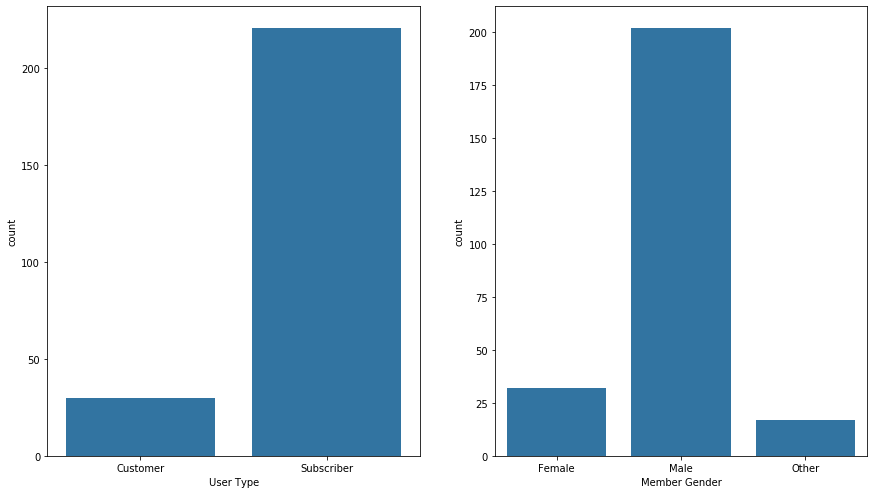

In [29]:
plt.figure(figsize=[14.70, 8.27])
plt.tight_layout()
plt.subplot(1,2,1)
sb.countplot(data = min_df, x = 'user_type', color = base_color)
plt.xlabel('User Type');
plt.subplot(1,2,2)
sb.countplot(data = min_df, x = 'member_gender', color = base_color)
plt.xlabel('Member Gender');

There 251 trips with the minimum duration of 61s, of which 221 are made by subscribers and just 30 by customers. As we can expect most of the users are Men.  

**Durations with the max number of trips**

In [50]:
# Calucalate the duration groups(too slow with for loop, better use list comprehension)
baywheels_data['duration_groups'] = ['0-15min' if duration <=900 else '15-30min' if duration <= 1800 else
                                     '30-60min' if duration <= 3600 else '1-5h' if duration <=18000 else
                                     '5-12h' if duration < 43200 else '12h++' 
                                     for duration in baywheels_data.duration_sec]

In [51]:
baywheels_data[['duration_groups', 'duration_sec']].sample(5)

,duration_groups,duration_sec
625778,0-15min,194
778079,0-15min,264
155714,0-15min,790
1332610,0-15min,205
172328,0-15min,425


In [52]:
# Turn the new created columns into category 
baywheels_data.duration_groups = pd.Categorical(baywheels_data.duration_groups, ordered = True, categories = ('0-15min', '15-30min','30-60min', '1-5h', '5-12h','12h++'))

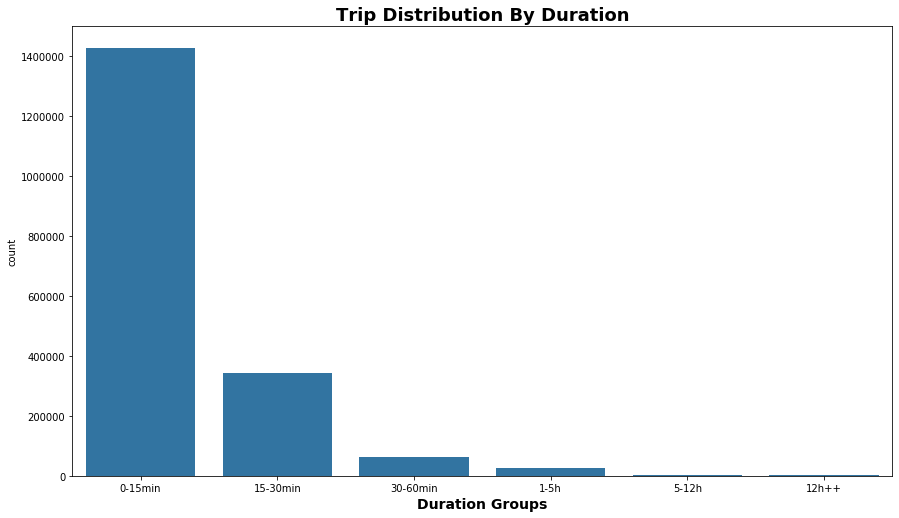

In [53]:
# Plot the differents group
plt.figure(figsize=[14.70, 8.27])
plt.title('Trip Distribution by Duration'.title(), fontsize = 18, weight = 'bold')
sb.countplot(data = baywheels_data, x = 'duration_groups', color = base_color)
plt.xlabel('Duration Groups'.title(), fontsize = 14, weight = 'bold');

There are more trip of less than 15mn, which means that in general and over the year all the trips are brief.

**15 *start* and *end* stations with the highest number of trips**

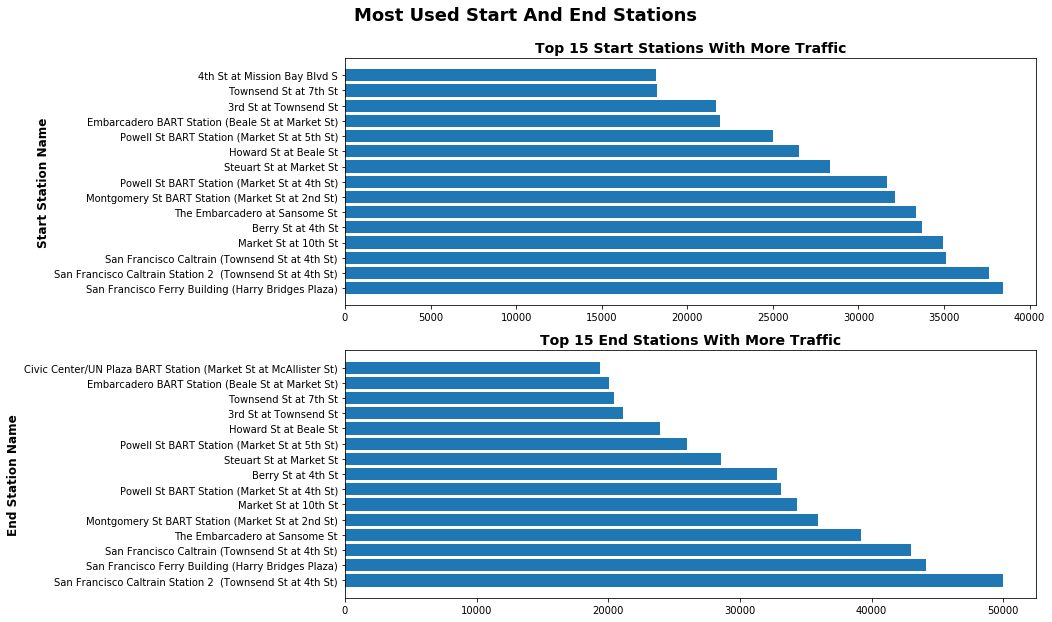

In [54]:

# Plot top 15 stations with the highest number of trip over the year
plt.figure(figsize=[14.70, 8.27])

plt.suptitle('Most Used Start and End Stations'.title(), fontsize = 18, weight = 'bold', y = 1.04)

# Retrieve the 15 start stations counts
start_counts = baywheels_data.start_station_name.value_counts()[:15]
# Retrieve the 15 start stations names
start_names = baywheels_data.start_station_name.value_counts()[:15].index
# Retrieve the 15 end stations counts
end_counts = baywheels_data.end_station_name.value_counts()[:15]
# Retrieve the 15 end stations names
end_names = baywheels_data.end_station_name.value_counts()[:15].index

# Plot the 15 start stations in the first subplot
plt.subplot(2,1,1)
plt.title('Top 15 start Stations with more Traffic'.title(), fontsize = 14, weight = 'bold')
y_position = np.arange(len(start_names))
plt.barh(y_position, start_counts, align = 'center')
plt.yticks(y_position, start_names)
plt.ylabel('Start station Name'.title(), fontsize = 12, weight = 'bold')

# Plot the 15 start stations in the second subplot
plt.subplot(2,1,2)
plt.title('Top 15 end Stations with more Traffic'.title(), fontsize = 14, weight = 'bold')
y_position = np.arange(len(end_names))
plt.barh(y_position, end_counts, align = 'center')
plt.yticks(y_position, end_names)
plt.ylabel('End station Name'.title(), fontsize = 12, weight = 'bold')
# Optimize the distance between plots
plt.tight_layout();

In [55]:
baywheels_data.start_station_name.value_counts().head(15)[baywheels_data.start_station_name.value_counts()
                                                          .head(15).index.isin(baywheels_data.end_station_name
                                                          .value_counts().head(15).index)==False]

4th St at Mission Bay Blvd S    18150
Name: start_station_name, dtype: int64

Just one station(4th St at Mission Bay Blvd S)is not in either lists(start and end) of the 15 stations with the highest trips, so the other 14 even if in different order are the same in start and end. These stations are the ones with more traffic, the company may think about increasing the number of bikes in those stations because they are surely too busy, If you want a quiet place avoid those stations!!

**15 start and end stations with the lowest number of trips**

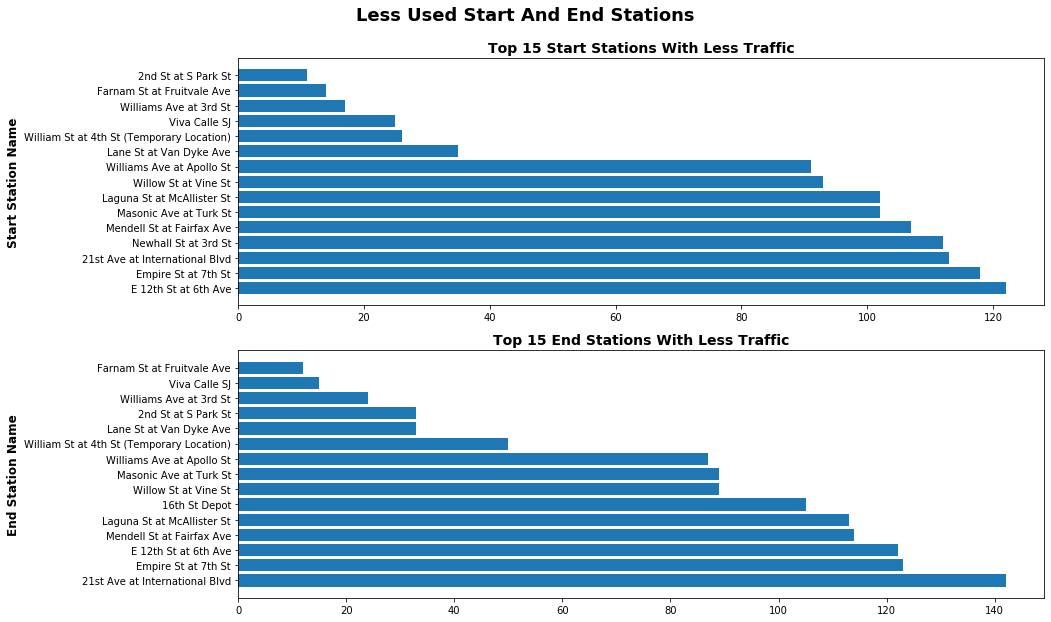

In [57]:
# Plot top 15 stations with the lowest number of trips over the year
plt.figure(figsize=[14.70, 8.27])

plt.suptitle('Less Used Start and End Stations'.title(), fontsize = 18, weight = 'bold', y = 1.04)
# Retrieve the 15 start stations counts
start_counts_2 = baywheels_data.start_station_name.value_counts().tail(15)
# Retrieve the 15 start stations names
start_names_2 = baywheels_data.start_station_name.value_counts().tail(15).index
# Retrieve the 15 end stations counts
end_counts_2 = baywheels_data.end_station_name.value_counts().tail(15)
# Retrieve the 15 end stations names
end_names_2 = baywheels_data.end_station_name.value_counts().tail(15).index
# Plot the 15 start stations in the first subplot
plt.subplot(2,1,1)
plt.title('Top 15 start Stations with less Traffic'.title(), fontsize = 14, weight = 'bold')
y_position = np.arange(len(start_names_2))
plt.barh(y_position, start_counts_2, align = 'center')
plt.yticks(y_position, start_names_2)
plt.ylabel('Start station Name'.title(), fontsize = 12, weight = 'bold')

# Plot the 15 start stations in the second subplot
plt.subplot(2,1,2)
plt.title('Top 15 end Stations with less Traffic'.title(), fontsize = 14, weight = 'bold')
y_position = np.arange(len(end_names_2))
plt.barh(y_position, end_counts_2, align = 'center')
plt.yticks(y_position, end_names_2)
plt.ylabel('End station Name'.title(), fontsize = 12, weight = 'bold')
# Optimize the distance between plots
plt.tight_layout();

In [58]:
# Stations that are not in lowest 15 start and end 
baywheels_data.start_station_name.value_counts().tail(15)[baywheels_data.start_station_name.value_counts()
                                                          .tail(15).index.isin(baywheels_data.end_station_name
                                                          .value_counts().tail(15).index)==False]

Newhall St at 3rd St    112
Name: start_station_name, dtype: int64

Here, we have the stations with less traffic during the year, there are stations like *Farnam St at Fruitvale Ave* with less than **20** trips all the year, In those stations you are almost sure to find a bike available. We cannot exactly know why those stations have so few trips, we do not have enough data, maybe the area has few people living there or there is no tourism or maybe there are not enough bikes available. With more data we could answer these questions.

## Bivariate Exploration  
Let us see if there is a correlation between the numerics variables.  

In [38]:
# Put all the numeric variables in a list
numeric_vars = ['duration_sec', 'start_station_id', 'end_station_id', 'bike_id', 'member_birth_year']
# Put all the categorical variables in a list
categoric_vars = ['member_gender', 'user_type', 'bike_share_for_all_trip']

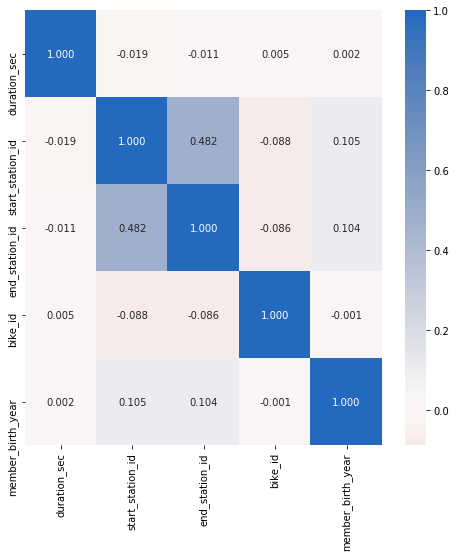

In [39]:
# Change the size plot
plt.figure(figsize = [8,8])
# Plot the heatmap with the correlations
sb.heatmap(baywheels_data[numeric_vars].corr(), annot = True, fmt = '.3f', cmap = 'vlag_r', center = 0);

As we could expected there is no correlation between all the ids variables and the duration of the trip, there is
no correlation between the member birth year and the duration of the trip, but thinking about it, it is probably 
due to the fact that even if these variables these variables are numeric they are to consider categorical, for
example the bike_id is a unique value given to each bike to identify it.

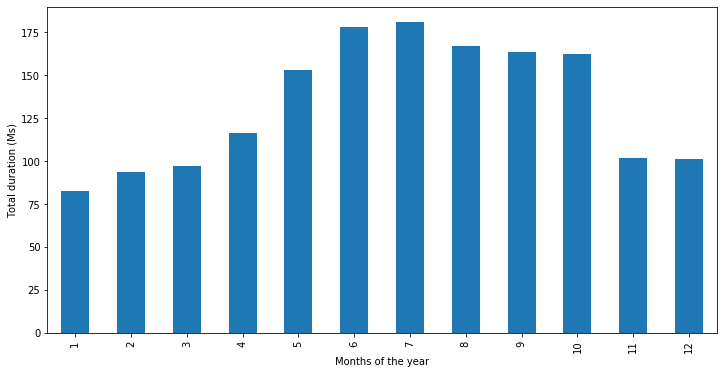

In [40]:
# Plot the total duration of the trip each month 
plt.figure(figsize = [12,6])
duration_per_hour = baywheels_data.groupby(months).sum().duration_sec/1e6 # Divide by 1e6 to have it in Mega seconds
duration_per_hour.plot(kind = 'bar')
plt.xlabel('Months of the year')
plt.ylabel('Total duration (Ms)');

We have the peaks at june and july. From may to october we have a total duration per month higher than **125 Mega seconds** which means more than **34722** hours. 

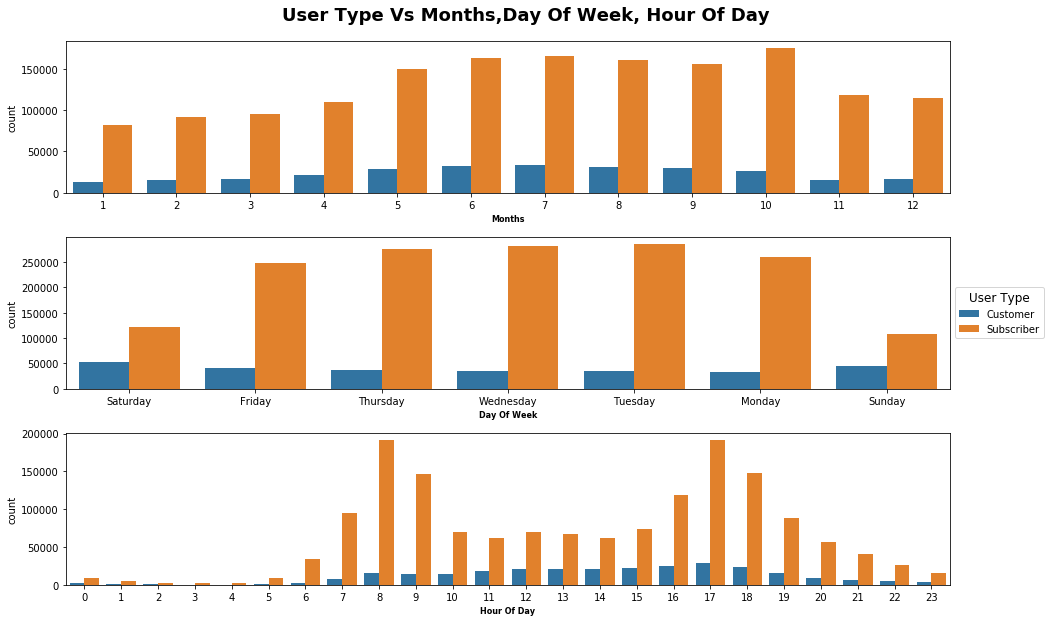

In [59]:
# Plot months of the year vs user_type
plt.figure(figsize=[14.70, 8.27])
# Optimize the distance between plots

plt.suptitle('User Type vs Months,Day of Week, Hour of Day'.title(), fontsize = 18, weight = 'bold', y = 1.04)

# Subplot months vs user type
plt.subplot(3,1,1)
sb.countplot(data = baywheels_data, x = months, hue = 'user_type')
plt.xlabel('Months'.title(), fontsize = 8, weight = 'bold')
plt.legend().remove()

# Subplot day of week vs user type
plt.subplot(3,1,2)
sb.countplot(data = baywheels_data, x = week_name, hue = 'user_type')
plt.xlabel('Day of Week'.title(), fontsize = 8, weight = 'bold')
plt.legend(loc ='center left', bbox_to_anchor = (1, 0.5), title = 'User Type', title_fontsize = 12)


# Subplot hour of day  vs user type
plt.subplot(3,1,3)
sb.countplot(data = baywheels_data, x = hours, hue = 'user_type')
plt.xlabel('Hour of Day'.title(), fontsize = 8, weight = 'bold')
plt.legend().remove()
plt.tight_layout();

`Subcribers` and `Customers` do not follow the same pattern, for example there are more trips of `Customers` at July and during the Weekends, while for `Subscribers` this occurs at October and during the Weekdays.  
During the day Customers have more trips between 11am and 6pm while for `Subscribers` this happens between 7am to 9am and 4pm to 9pm.

## Multivariate Exploration

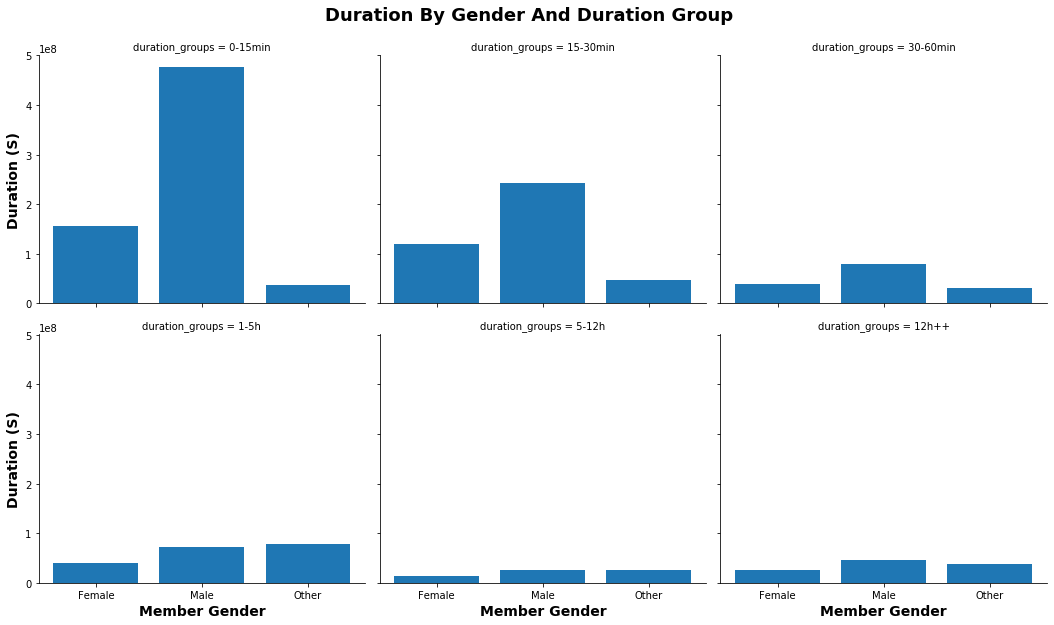

In [60]:
# Group by duration group and member gender then sum the duration sec, reset index to have a dataframe
gender_duration_group = baywheels_data.groupby(['duration_groups','member_gender']).sum().duration_sec.reset_index()
# Facet per duration Groups

g = sb.FacetGrid(data = gender_duration_group, col = 'duration_groups', height = 8.27/2, col_wrap =3, aspect = (14.70/3)/(8.27/2))
g.map(plt.bar, 'member_gender', 'duration_sec')
plt.suptitle('Duration by Gender and Duration Group'.title(), fontsize = 18, weight = 'bold', y = 1.04)
g.set_xlabels('Member gender'.title(), fontsize = 14, weight = 'bold')
g.set_ylabels('Duration (s)'.title(), fontsize = 14, weight = 'bold');

In general, Women have less trips duration than Men no matter the group of duration.The *Other* category in the group of duration 1-5 hours has more duration time than the Male and Female categories.  

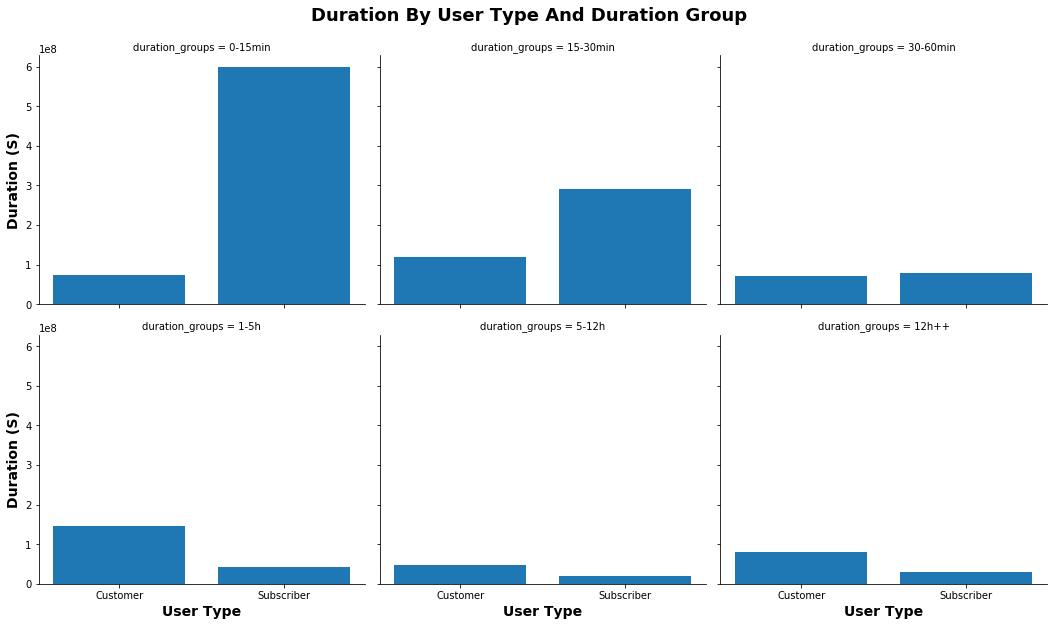

In [63]:
# Group by duration and user type then calculate the total duration for the group and reset index to have df
user_duration_group = baywheels_data.groupby(['duration_groups','user_type']).sum().duration_sec.reset_index()
# Facet per duration Groups
g = sb.FacetGrid(data = user_duration_group, col = 'duration_groups', height = 8.27/2, col_wrap = 3, aspect = (14.70/3)/(8.27/2))
g.map(plt.bar, 'user_type', 'duration_sec')
plt.suptitle('Duration by User Type and Duration Group'.title(), fontsize = 18, weight = 'bold', y = 1.04)
g.set_xlabels('User Type'.title(), fontsize = 14, weight = 'bold')
g.set_ylabels('Duration (s)'.title(), fontsize = 14, weight = 'bold');

Subscribers tend to have brief trips(less than 1 hour) than Customers, in fact from 1h to more than 12 hours
Customers have a total duration trip higher than Subscribers.

## Conclusions 

After analyzing 1863721 trips of the Ford Go bike System of San Francisco, **85%** of the trips are made by Subscribers and just **15%** by Customers. Men have more trips than Women, **69.1%** for Men against **23.5%** 
for Women.  
The brand new option **Bike Share for all** is not really used. In 2018 just **8.7%** of Users use the option. 
In general the bikes are used by young people with an average age of 35 years old.  
The period of the year with the highest number of trips is October for the Subscribers and July for the Customers. Subcribers tend to use bike during the working days while Customers use it more during the weekends.  
Some of the stations are very trafficated while others have less than 20 trips all the year. With more data(population of the Area, occupation) we will be able to understand why such stations have more or less trips, but this will be the subject of another Study.
